In [1]:
import os

from sklearn.metrics import classification_report

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import pandas as pd
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-01-26 07:01:48.495288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737874908.553295    6354 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737874908.570889    6354 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


In [331]:
df = pd.read_csv('../data/cereal.csv')
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


$$
\text{mfr - Manufacturer of cereal, type - cold or hot, display shelf - 1, 2, or 3, etc.}
$$


In [332]:
for col in ['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins']:
    print(col, (df[col] < 0).sum())

calories 0
protein 0
fat 0
sodium 0
fiber 0
carbo 1
sugars 1
potass 2
vitamins 0


In [333]:
df['potass'] = df['potass'].replace(-1, np.median(df['potass']))
df['carbo'] = df['carbo'].replace(-1, np.median(df['carbo']))
df['sugars'] = df['sugars'].replace(-1, np.median(df['sugars']))


$$
\text{Plotting the data}
$$

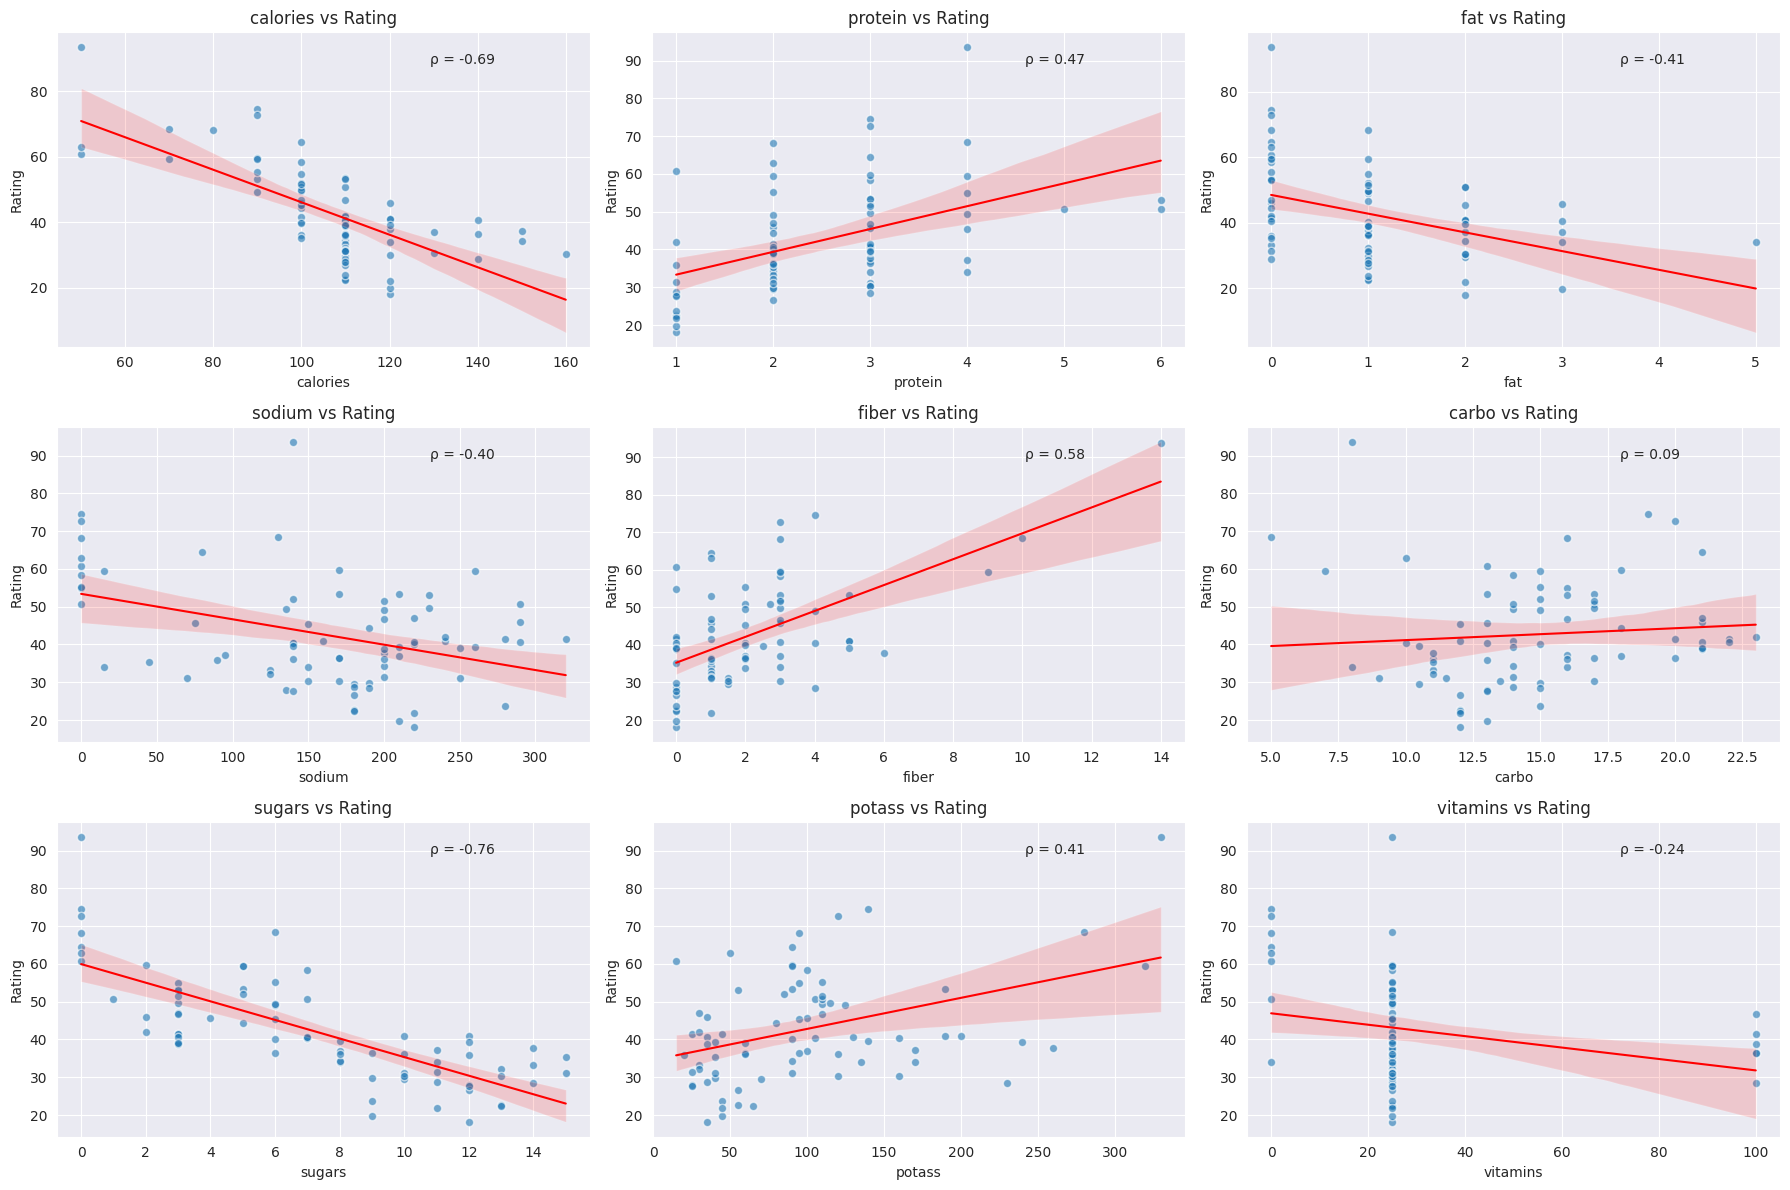

In [334]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

features = ['calories', 'protein', 'fat', 'sodium', 'fiber',
            'carbo', 'sugars', 'potass', 'vitamins']

for i, col in enumerate(features):
    axes[i].scatter(df[col], df['rating'], alpha=0.6, edgecolor='w')

    sns.regplot(x=df[col], y=df['rating'],
                scatter=False, ax=axes[i],
                line_kws={'color':'red', 'lw':1.5})

    corr = np.corrcoef(df[col], df['rating'])[0,1]
    axes[i].annotate(f'ρ = {corr:.2f}', xy=(0.7, 0.9),
                     xycoords='axes fraction', fontsize=10)

    axes[i].set_title(f'{col} vs Rating', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Rating')

plt.tight_layout()
plt.show()

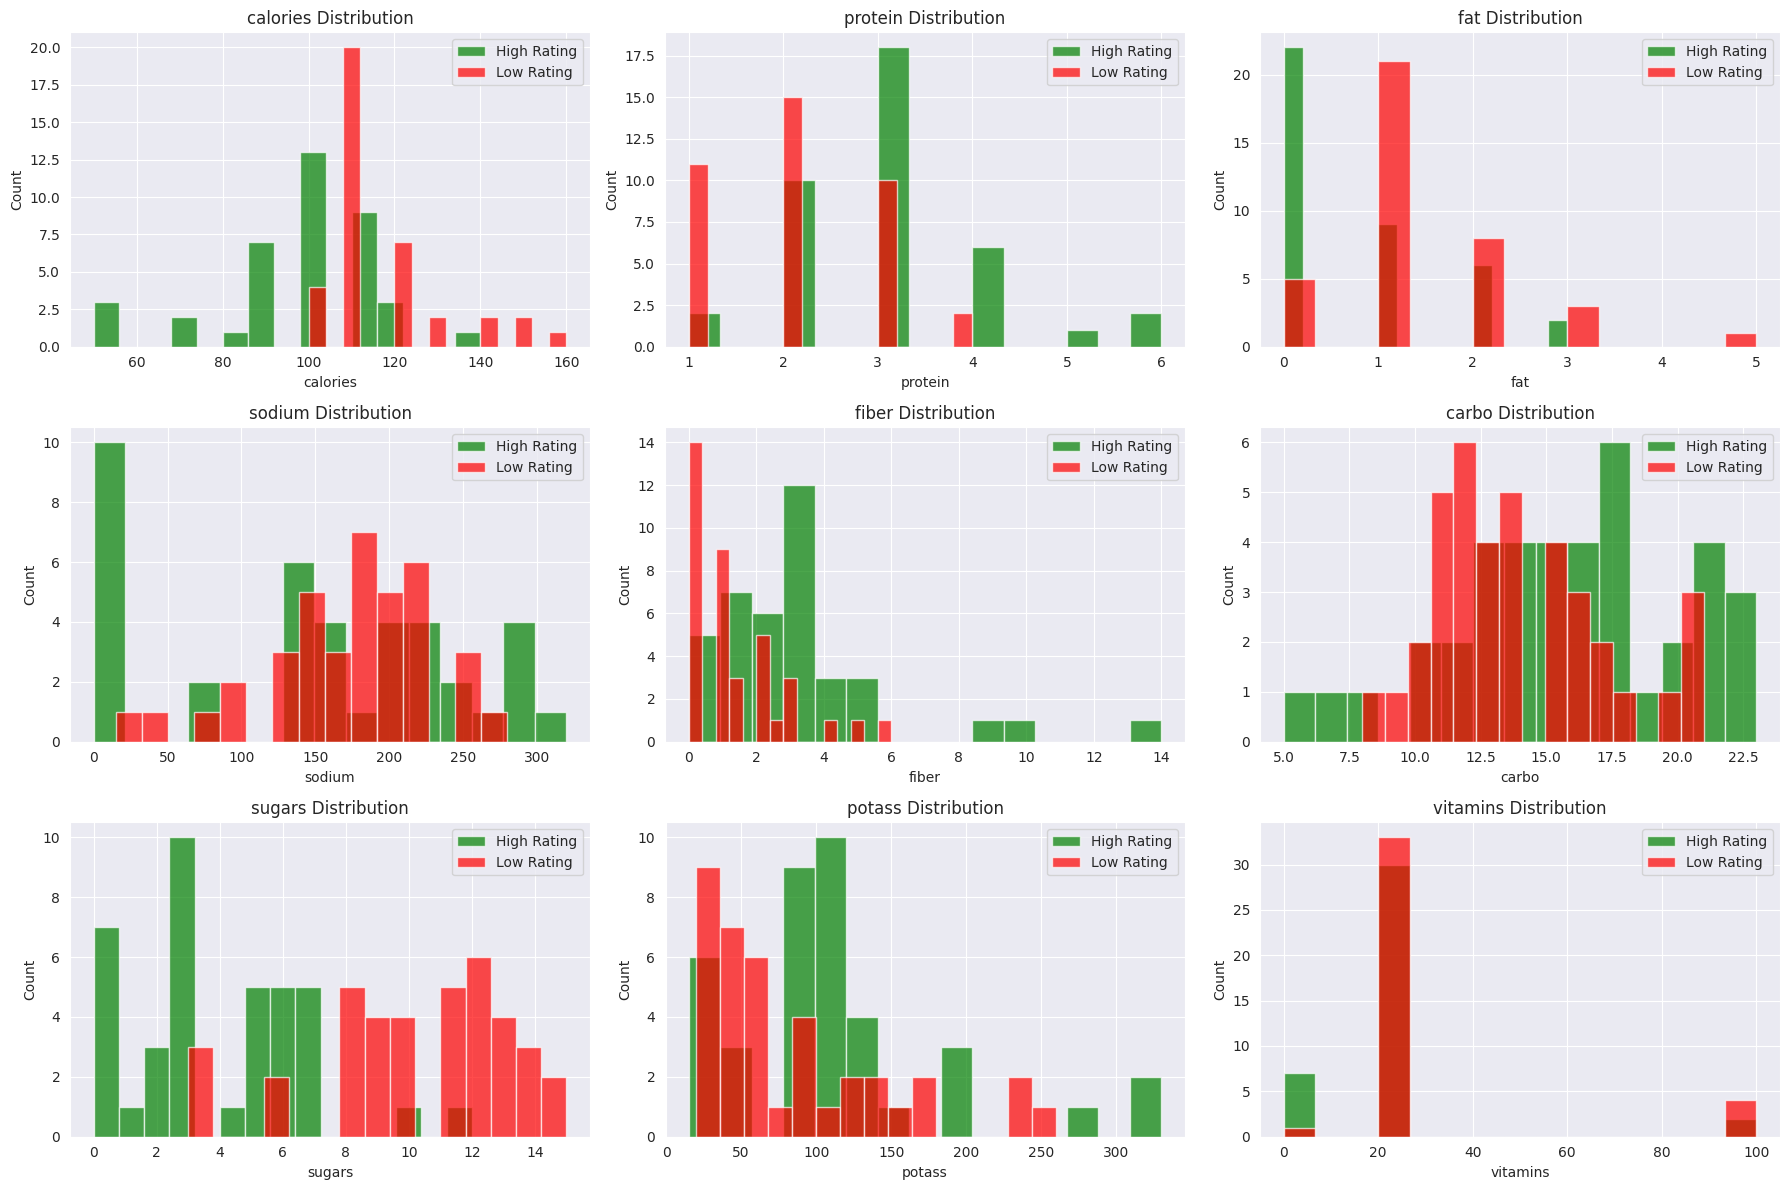

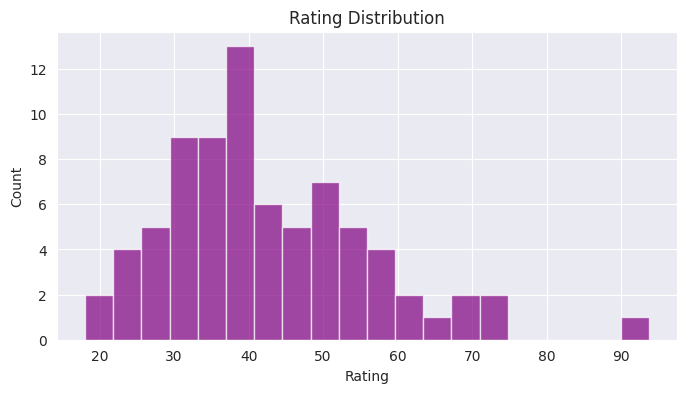

In [335]:
import matplotlib.pyplot as plt

# Split cereals into high/low rating groups
median_rating = df['rating'].median()
high_rating = df[df['rating'] >= median_rating]
low_rating = df[df['rating'] < median_rating]

# Set up 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

features = ['calories', 'protein', 'fat', 'sodium', 'fiber',
            'carbo', 'sugars', 'potass', 'vitamins']

for i, col in enumerate(features):
    # Plot histograms for high/low rating groups
    axes[i].hist(high_rating[col], bins=15, alpha=0.7,
                 color='green', label='High Rating')
    axes[i].hist(low_rating[col], bins=15, alpha=0.7,
                 color='red', label='Low Rating')

    axes[i].set_title(f'{col} Distribution', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Plot rating distribution separately
plt.figure(figsize=(8, 4))
plt.hist(df['rating'], bins=20, color='purple', alpha=0.7)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

$$
\text{Final Data Preprocessing}
$$

In [336]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(columns=['rating', 'name'])
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins', 'weight', 'cups']

categorical_features = ['mfr', 'type', 'shelf']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [337]:
print("Columns in X:", X.columns.tolist())
# Output should NOT include 'rating'

Columns in X: ['mfr', 'type', 'calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins', 'shelf', 'weight', 'cups']


$$
\text{Split Data}
$$

In [338]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [339]:
print("X_train shape:", X_train_processed.shape)
print("y_train shape:", y_train.shape)

X_train shape: (61, 23)
y_train shape: (61,)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
    (X_train_processed.astype(np.float32), y_train.values.astype(np.float32))
)
test_data = tf.data.Dataset.from_tensor_slices(
    (X_test_processed.astype(np.float32), y_test.values.astype(np.float32))
)

In [321]:
# Batch and prefetch for GPU acceleration
BATCH = 16
train_data = train_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)


In [1]:
from tensorflow.keras.models import Sequential

model = Sequential([
    tf.keras.layers.Input(shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

2025-01-26 08:00:48.237305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 08:00:48.245011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737878448.254075   14787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737878448.256762   14787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 08:00:48.265804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'tf' is not defined

In [323]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
)

In [324]:
history = model.fit(
    train_data,
    epochs=100,
    verbose=0,
    validation_data=test_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]

)

In [325]:
test_loss, test_mae, test_rmse = model.evaluate(test_data)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0055 - mae: 1.7959 - root_mean_squared_error: 2.2373
Test RMSE: 2.24
Test MAE: 1.80


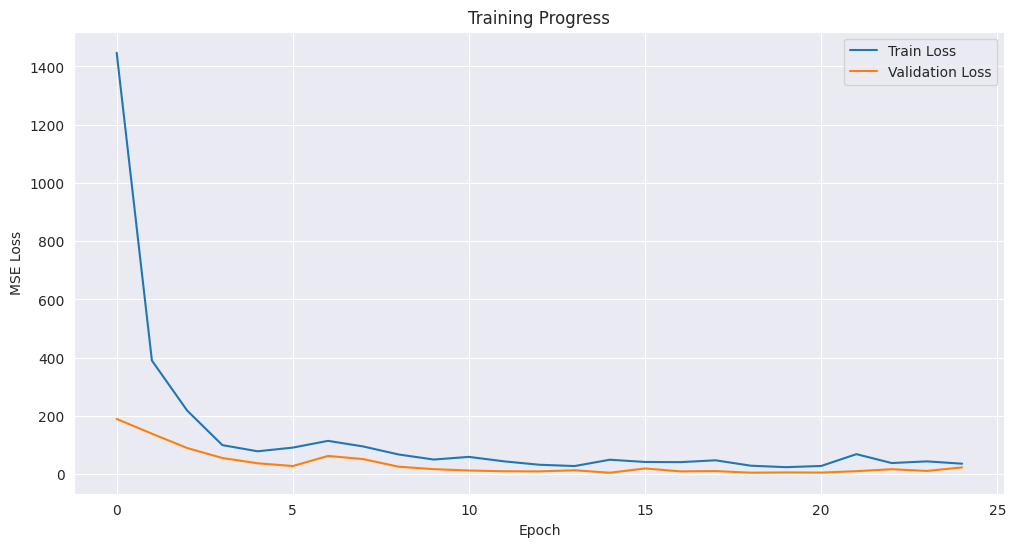

In [326]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

$$
\text{Training RMSE: 3.5218 → Predictions are ±3.5218rating units off on average}
$$
$$
\text{Validation RMSE: 2.8064 → Better generalization to unseen data}
$$
$$
\text{Test RMSE: 2.72 → Predictions are ±2.72 rating units off on average}
$$

In [327]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test_processed)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"""
Regression Metrics:
- MAE (Mean Absolute Error): {mae:.2f}
- RMSE (Root Mean Squared Error): {rmse:.2f}
- R² (R-squared): {r2:.2%}
""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

Regression Metrics:
- MAE (Mean Absolute Error): 1.80
- RMSE (Root Mean Squared Error): 2.24
- R² (R-squared): 97.72%



In [328]:
train_r2 = r2_score(y_train, model.predict(X_train_processed))
test_r2 = r2_score(y_test, y_pred)
print(f"Train R²: {train_r2:.2%}, Test R²: {test_r2:.2%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Train R²: 95.41%, Test R²: 97.72%


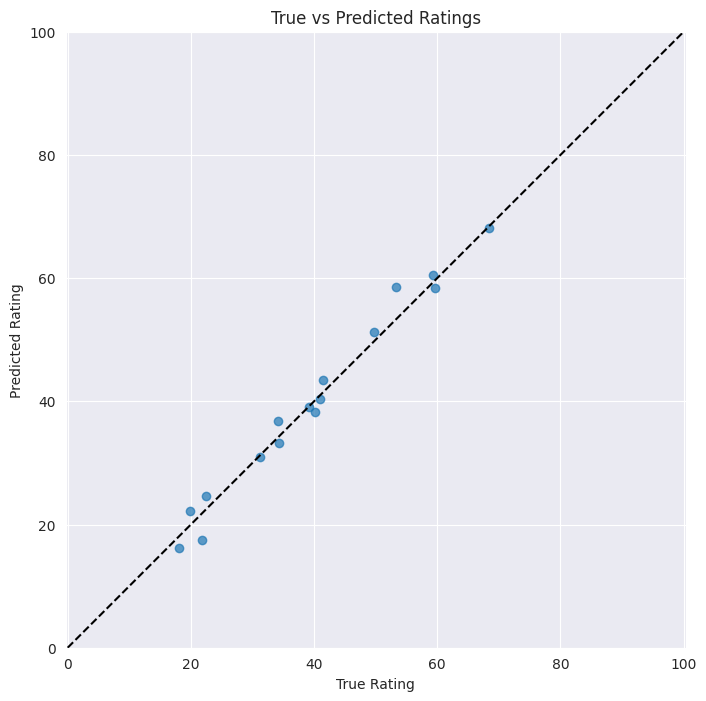

In [329]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0, 100], [0, 100], '--k')
plt.axis('equal')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('True vs Predicted Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()
